In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [2]:
### Function to convert dataframe to timeseries object
def create_ts_object(df):
    df.Timestamp = pd.to_datetime(df.Timestamp)
    df.set_index("Timestamp", inplace=True)
    df = df.asfreq('H')

    return df.head()

### Import Digester 21 data

In [3]:
data21 = pd.read_csv("~/Documents/Data/FinalDatasetForModel/Digester21data.csv")
data21.drop(['Dig_21_woodload', 'Dig_21_Liq_circ',
       'Digester_21_temperature', 'Digester_21_pressure',
       'Dig_21_phase_Comm Fail', 'Dig_21_phase_Configure',
       'Dig_21_phase_HP GAS RELEASE', 'Dig_21_phase_LIQUOR LOADING',
       'Dig_21_phase_LP GAS RELEASE', 'Dig_21_phase_PULP DISCHARGE',
       'Dig_21_phase_READY FOR LIQUOR',
       'Dig_21_phase_READY FOR PULP DISCH',
       'Dig_21_phase_READY FOR STEAMING', 'Dig_21_phase_READY FOR WOOD',
       'Dig_21_phase_SFACTOR TGT REACHED',
       'Dig_21_phase_SMOOTH STEAM FIXED',
       'Dig_21_phase_SMOOTH STEAM RAMP', 'Dig_21_phase_Scan Timeout',
       'Dig_21_phase_TEMP RAMP TO 110C', 'Dig_21_phase_TEMP RAMP TO 126C',
       'Dig_21_phase_TEMP RAMP TO TMAX', 'Dig_21_phase_VALVE CHECK',
       'Dig_21_phase_WOODLOAD COMPLETE', 'Dig_21_phase_WOODLOADING'], axis = 1, inplace=True)

create_ts_object(data21)

,Dig_21_HX
Timestamp,
2020-11-01 00:00:00,2.045813
2020-11-01 01:00:00,5.499927
2020-11-01 02:00:00,1.298724
2020-11-01 03:00:00,0.460020
2020-11-01 04:00:00,0.010706


### Stationarity

In [4]:
sts.adfuller(data21.Dig_21_HX)

(-12.527899397671725,
 2.4653043848434702e-23,
 11,
 2197,
 {'1%': -3.433329953061165,
  '5%': -2.8628564476416725,
  '10%': -2.5674708095410446},
 11020.310113815576)

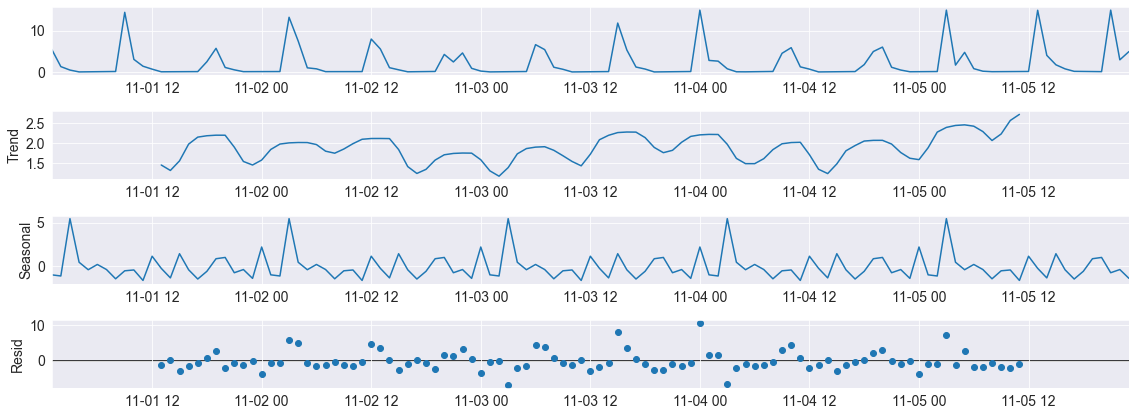

In [5]:
seas_dec = seasonal_decompose(data21[1:120], model = "additive")
seas_dec.plot()
plt.show()

### ACF

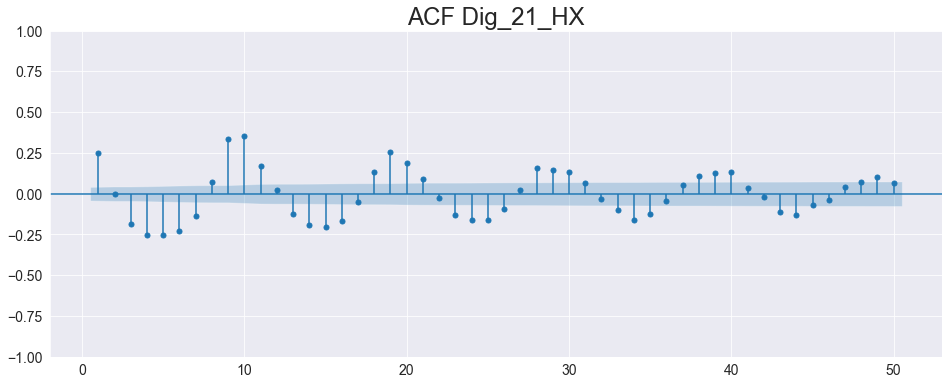

In [6]:
sgt.plot_acf(data21.Dig_21_HX, lags = 50, zero = False)
plt.title("ACF Dig_21_HX", size = 24)
plt.show()

### PACF

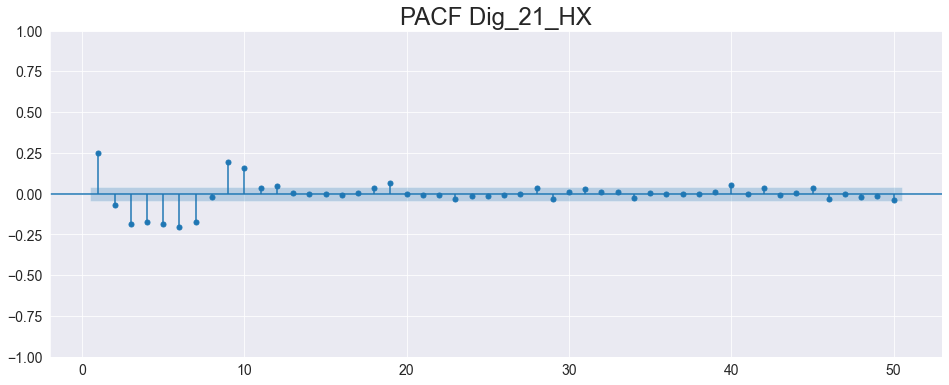

In [7]:
sgt.plot_pacf(data21.Dig_21_HX, lags = 50, zero = False, method = ('ols'))
plt.title("PACF Dig_21_HX", size = 24)
plt.show()

In [8]:
#  Spare copy
data21_twin1 = data21.copy()

### Normalization

In [9]:
# define functions to scale and reverse-scale data, looping through the columns, and passing a scaler type
def scale_data(data, scaler):
    for col in data.columns.values:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data.head()

In [10]:
scaler = MinMaxScaler()
data21_twin = data21.copy()
scale_data(data21_twin, scaler)

,Dig_21_HX
Timestamp,
2020-11-01 00:00:00,0.136388
2020-11-01 01:00:00,0.366662
2020-11-01 02:00:00,0.086582
2020-11-01 03:00:00,0.030668
2020-11-01 04:00:00,0.000714


### Data Split

In [11]:
train_size = int(len(data21_twin)*0.85)
val_size = train_size + int(len(data21_twin)*0.10)
train_data21 = data21_twin.iloc[:train_size]
val_data21 = data21_twin.iloc[train_size:val_size]
test_data21 = data21_twin.iloc[val_size:]

In [12]:
val_data21.head()

,Dig_21_HX
Timestamp,
2021-01-18 05:00:00,0.0
2021-01-18 06:00:00,0.0
2021-01-18 07:00:00,0.0
2021-01-18 08:00:00,0.0
2021-01-18 09:00:00,0.0


### Auto ARIMA Model

In [13]:
model_auto = auto_arima(train_data21.Dig_21_HX, max_order = None, max_p = 30, max_q = 40, maxiter = 100, alpha = 0.05, n_jobs = -1, trend = 'ct',)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [14]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1877
Model:              SARIMAX(10, 0, 0)   Log Likelihood                 328.920
Date:                Sat, 12 Mar 2022   AIC                           -631.840
Time:                        13:00:31   BIC                           -559.854
Sample:                             0   HQIC                          -605.323
                               - 1877                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1681      0.015     10.928      0.000       0.138       0.198
drift       8.551e-06   8.77e-06      0.976      0.329   -8.63e-06    2.57e-05
ar.L1          0.0484      0.026      1.859      0.063      -0.003       0.099
ar.L2         -0.0660      0.041     -1.594      0.111      -0.147       0.015
ar.L3         -0.1523      0.099     -1.545      0.122      -0.346       0.041
ar.L4         -0.1393      0.125     -1.112      0.266      -0.385       0.106
ar.L5         -0.1200      0.121     -0.988      0.323      -0.358       0.118
ar.L6         -0.1304      0.098     -1.328      0.184      -0.323       0.062
ar.L7         -0.1397      0.053     -2.659      0.008      -0.243      -0.037
ar.L8         -0.0453      0.027     -1.651      0.099      -0.099       0.008
ar.L9          0.1762      0.016     11.000      0.000       0.145       0.208
ar.L10         0.1576      0.015     10.366      0.000       0.128       0.187
sigma2         0.0411      0.001     36.425      0.000       0.039       0.043
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              3762.27
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             2.01
Prob(H) (two-sided):                  0.56   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA Model Residual Analysis

In [15]:
data21_resid_dataset = train_data21.copy()
data21_resid_dataset['residuals'] = model_auto.resid()

In [16]:
print(data21_resid_dataset.residuals.mean())
print(data21_resid_dataset.residuals.var())

0.0001940356287145336
0.04124463684388594


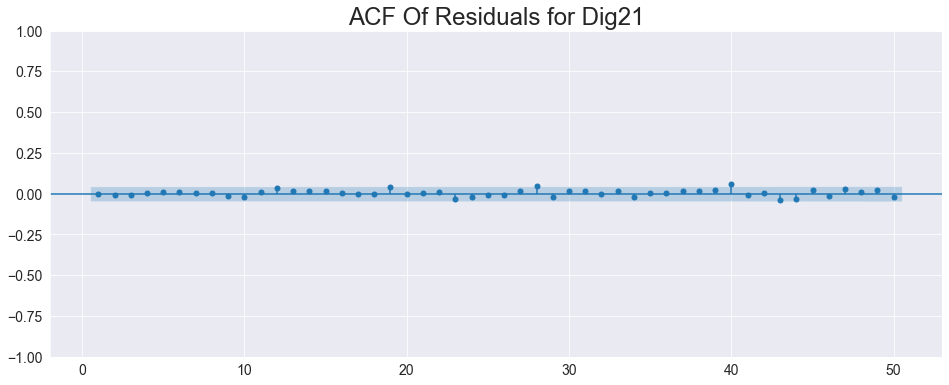

In [17]:
sgt.plot_acf(data21_resid_dataset.residuals, zero = False, lags = 50)
plt.title("ACF Of Residuals for Dig21",size=24)
plt.show()

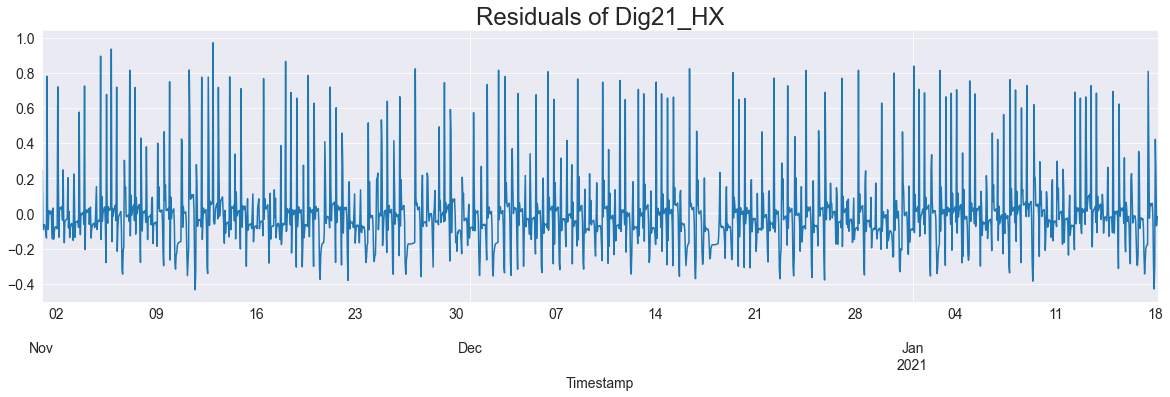

In [18]:
data21_resid_dataset.residuals.plot(figsize=(20,5))
plt.title("Residuals of Dig21_HX",size=24)
plt.show()

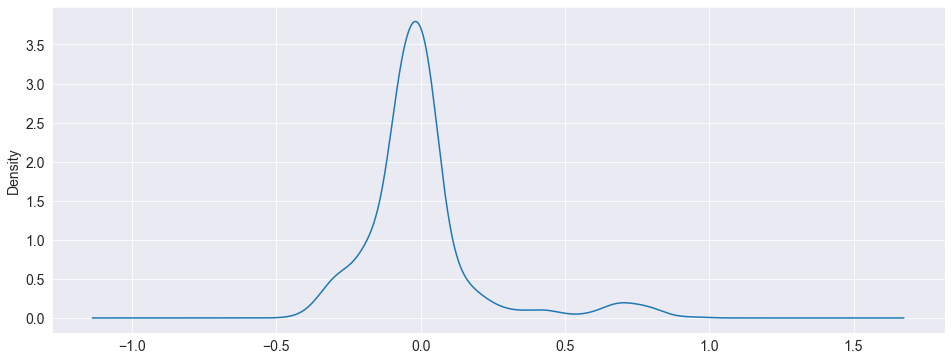

In [19]:
data21_resid_dataset.residuals.plot(kind='kde')
plt.show()

### Model Validation

In [20]:
start_date = "2021-01-18 05:00:00"
end_date = "2021-01-27 08:00:00"

In [21]:
df_pred = pd.DataFrame(model_auto.predict(n_periods = len(val_data21), index = val_data21.index))

In [22]:
scaler2 = MinMaxScaler()
scaler2.fit_transform(data21_twin1.Dig_21_HX.values.reshape(-1, 1))

array([[0.13638755],
       [0.36666177],
       [0.08658162],
       ...,
       [0.99613635],
       [0.37754752],
       [0.30963411]])

In [23]:
# Invert the scale of predictions
df_pred2 = scaler2.inverse_transform(df_pred.values.reshape(-1, 1))

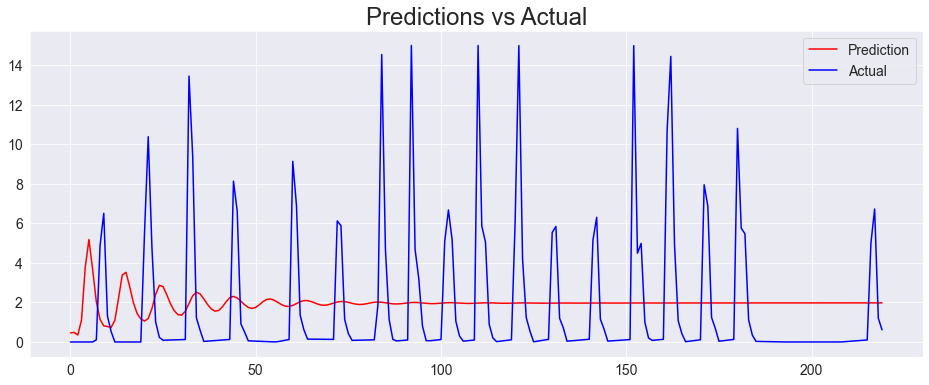

In [24]:
plt.plot(df_pred.index.to_numpy(), df_pred2, color = "red")
plt.plot(df_pred.index, data21_twin1.Dig_21_HX[start_date:end_date].to_numpy(), color = "blue")
plt.legend(['Prediction', 'Actual'])
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Performance Metrics

In [25]:
ndapred, ndaactual = df_pred, val_data21.Dig_21_HX.to_numpy()

In [26]:
print(ndapred.shape)
print(ndaactual.shape)

(220, 1)
(220,)


In [27]:
print("MAE: %.4f" %mean_absolute_error(ndaactual, ndapred))
print("RMSE: %.4f" %np.sqrt(mean_squared_error(ndaactual, ndapred)))

MAE: 0.1699
RMSE: 0.2274


In [28]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig21pred.npy", df_pred2)

### Forecast

In [29]:
fcast = pd.DataFrame(model_auto.predict(n_periods = len(test_data21), index = test_data21.index))

In [33]:
fcast = scaler2.inverse_transform(fcast.values.reshape(-1, 1))

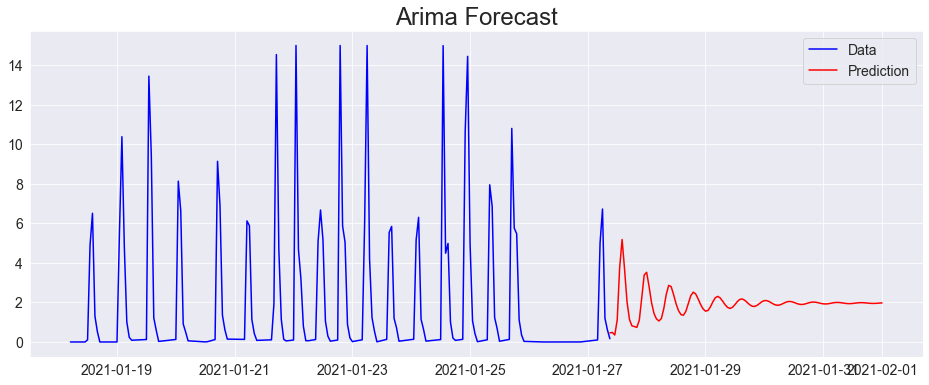

In [34]:
plt.plot(data21_twin1.index[1877:2098], data21_twin1.Dig_21_HX[1877:2098].to_numpy(), color = "blue")
plt.plot(test_data21.index, fcast, color = "red")
plt.legend(['Data', 'Prediction'])
plt.title("Arima Forecast", size = 24)
plt.show()

In [32]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/Dig21fcast.npy", fcast)